In [30]:
from ipynb.fs.full.utils import *
#from ipynb.fs.full.exsitu_calculation import *
#from ipynb.fs.full.calculate_mw_met_age import *
#from ipynb.fs.full.offsets import *

%run exsitu_calculation.ipynb 
%run calculate_mw_met_age.ipynb 
%run offsets.ipynb 

import numpy as np
import h5py
import pandas as pd
import sys
import illustris_python.illustris_python as il
import matplotlib.pyplot as plt
import os
from multiprocessing import Pool
import tqdm


sim_dir = '1P_2'

basePath = '/home/jovyan/Data/Sims/IllustrisTNG/{}/'.format(sim_dir)

In [31]:
def calc_offsets_sim(sim_dir):
    offsets_dir = 'Offsets/IllustrisTNG/{}'.format(sim_dir)
    if not os.path.exists(offsets_dir):
        os.makedirs(offsets_dir)

    pool = Pool(processes=4)
    results = list(tqdm.tqdm(pool.starmap(create_offsets, zip(range(34), repeat(sim_dir))), 
                             total=34))
    pool.close()
    pool.join()

    
def calc_met_age_sim(sim_dir):
    basePath = '/home/jovyan/Data/Sims/IllustrisTNG/{}/'.format(sim_dir)
    met_age_dir = 'MetAge/IllustrisTNG/{}'.format(sim_dir)
    if not os.path.exists(met_age_dir):
        os.makedirs(met_age_dir)

    for snapshot in range(29, 34):
        (scaling_factor, hubble_param,
            boxsize, omega0, omegaLambda) = get_snapshot_values(basePath, snapshot)
        tng = get_catalog_data(basePath, snapshot, scaling_factor, hubble_param)
        galaxy_ids = list(tng.GalaxyID)

        pool = Pool(processes=4)
        results = list(tqdm.tqdm(pool.starmap(get_mass_weighted_age_met, 
                                              zip(galaxy_ids, repeat(snapshot), repeat(sim_dir))), 
                                 total=len(galaxy_ids)))

        pool.close()
        pool.join()

        met, age = map(list, zip(*results))
        met_age_dict = {'GalaxyID': galaxy_ids, 'Metallicity': met, 'Age': age}
        df = pd.DataFrame(met_age_dict)

        save_path = os.path.join(met_age_dir, 'met_age_%03d.hdf5' % snapshot)
        df.to_hdf(save_path, '/data')

        
def calc_exsitu_sim(sim_dir):
    basePath = '/home/jovyan/Data/Sims/IllustrisTNG/{}/'.format(sim_dir)
    exsitu_dir = 'Exsitu/IllustrisTNG/{}'.format(sim_dir)
    if not os.path.exists(exsitu_dir):
        os.makedirs(exsitu_dir)

    for snapshot in range(29, 34):
        (scaling_factor, hubble_param,
            boxsize, omega0, omegaLambda) = get_snapshot_values(basePath, snapshot)
        tng = get_catalog_data(basePath, snapshot, scaling_factor, hubble_param)
        galaxy_ids = list(tng.GalaxyID)

        pool = Pool(processes=4)
        results = list(tqdm.tqdm(pool.starmap(get_exsitu_fraction, 
                                              zip(galaxy_ids, repeat(snapshot), repeat(sim_dir))), 
                                 total=len(galaxy_ids)))


        pool.close()
        pool.join()

        exsitu_dict = {'GalaxyID': galaxy_ids, 'ExsituF': results}
        df = pd.DataFrame(exsitu_dict)

        save_path = os.path.join(exsitu_dir, 'exsitu_%03d.hdf5' % snapshot)
        df.to_hdf(save_path, '/data')


In [ ]:
offsets_dir = 'Offsets/IllustrisTNG/{}'.format(sim_dir)
if not os.path.exists(offsets_dir):
    print('Calculating offsets for sim {}'.format(sim_dir))
    calc_offsets_sim(sim_dir)

exsitu_dir = 'Exsitu/IllustrisTNG/{}'.format(sim_dir)
if not os.path.exists(exsitu_dir):
    print('Calculating exsitu for sim {}'.format(sim_dir))
    calc_exsitu_sim(sim_dir)
    
met_age_dir = 'MetAge/IllustrisTNG/{}'.format(sim_dir)
if not os.path.exists(met_age_dir):
    print('Calculating MW Met and Age for sim {}'.format(sim_dir))
    calc_met_age_sim(sim_dir)

    
all_df = pd.DataFrame()
for snapshot in range(29, 34):
    (scaling_factor, hubble_param, boxsize, 
        omega0, omegaLambda) = get_snapshot_values(basePath, snapshot)
    tng_df = get_catalog_data(basePath, snapshot, scaling_factor, hubble_param)
    
    exsitu_path = os.path.join(exsitu_dir, 'exsitu_%03d.hdf5' % snapshot)
    ex_df = pd.read_hdf(exsitu_path, '/data')
    
    met_age_path = os.path.join(met_age_dir, 'met_age_%03d.hdf5' % snapshot)
    met_age_df = pd.read_hdf(met_age_path, '/data')

    tng_df = tng_df.merge(ex_df)
    tng_df = tng_df.merge(met_age_df)
    tng_df['Snapshot'] = snapshot
    print(len(tng_df))

    all_df = all_df.append(tng_df, ignore_index=True)


Calculating exsitu for sim 1P_2


In [25]:
all_df

,SubhaloSFRinRad,SubhaloMassStar,SubhaloMassGas,SubhaloMassBH,SubhaloMassDM,SubhaloSpin_x,SubhaloSpin_y,SubhaloSpin_z,SubhaloPos_x,SubhaloPos_y,SubhaloPos_z,SubhaloStarsLen,SubhaloGasLen,SubhaloHalfmassRadStar,GalaxyID,Central,ExsituF,Metallicity,Age,Snapshot
0,3.442959,60.962307,1.180924e+13,3.114777e+09,3.421885e+13,-3378.069092,5688.398926,6682.327637,7710.123535,12549.990234,3672.575439,68282,600812,40.895126,0,True,0.737494,1.299321,6.159481,29
1,2.743120,2.585599,1.754218e+11,1.132320e+08,5.624219e+11,425.944702,-419.892761,1807.820679,6964.750977,13719.347656,3509.559082,2713,8220,10.799788,1,False,0.322921,0.972250,4.834704,29
2,0.000000,5.877312,0.000000e+00,4.400786e+08,3.792124e+11,415.099243,60.158463,-224.338669,8739.265625,12141.532227,3770.653076,6655,0,6.388223,2,False,0.425091,1.295206,9.503272,29
3,0.935299,1.319513,4.983115e+10,4.793311e+07,2.180147e+11,109.669617,-49.615948,575.128235,7066.469727,12295.703125,2869.034668,1411,2244,5.615309,3,False,0.021669,0.905508,5.498469,29
4,0.186508,3.091168,5.364940e+09,1.600153e+08,2.026976e+11,318.517548,504.238556,-180.276886,7647.132324,13180.785156,3457.931152,3383,223,7.125452,4,False,0.232295,1.279706,6.848372,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,0.107355,0.124427,2.934762e+10,3.331670e+07,1.832796e+11,249.573074,-976.051147,-325.095764,22878.554688,13890.837891,9744.618164,118,1433,2.761415,1784,True,0.059194,0.473577,7.766498,33
1150,0.044486,0.114151,4.562822e+10,1.998489e+07,1.629502e+11,-606.244019,390.236633,783.076843,15042.743164,12881.760742,7199.318848,118,2249,8.659224,1795,True,0.147487,0.278218,9.256276,33
1151,0.664136,0.148310,5.290979e+10,2.071495e+07,1.417797e+11,454.232208,-238.824387,1363.198364,26691.121094,28417.140625,34998.761719,150,2569,8.124154,1801,True,0.049813,0.410523,5.991061,33
1152,0.136714,0.122010,4.129954e+10,3.581531e+07,1.236585e+11,385.537506,310.646027,-366.798218,23756.564453,37248.718750,26643.152344,121,2051,3.730887,1850,True,0.068798,0.382674,5.448548,33


In [26]:
final_df = pd.DataFrame()
for column in ('GalaxyID', 'Snapshot', 'ExsituF', 'Central', 'Age', 'Metallicity'):
    final_df[column] = all_df[column]

total_spin_x = all_df.SubhaloSpin_x
total_spin_y = all_df.SubhaloSpin_y
total_spin_z = all_df.SubhaloSpin_z
total_spin = np.sqrt(total_spin_x**2 + total_spin_y**2 + total_spin_z**2)    
    
final_df['Stellar_Mass'] = all_df['SubhaloMassStar']
final_df['Gas_Mass'] = all_df['SubhaloMassGas']
final_df['DM_Mass'] = all_df['SubhaloMassDM']
final_df['BH_Mass'] = all_df['SubhaloMassBH']
final_df['HMSR'] = all_df['SubhaloHalfmassRadStar']
final_df['TotalSpin'] = total_spin


In [27]:
final_df

,GalaxyID,Snapshot,ExsituF,Central,Age,Metallicity,Stellar_Mass,Gas_Mass,DM_Mass,BH_Mass,HMSR,TotalSpin
0,0,29,0.737494,True,6.159481,1.299321,60.962307,1.180924e+13,3.421885e+13,3.114777e+09,40.895126,9403.336914
1,1,29,0.322921,False,4.834704,0.972250,2.585599,1.754218e+11,5.624219e+11,1.132320e+08,10.799788,1904.193848
2,2,29,0.425091,False,9.503272,1.295206,5.877312,0.000000e+00,3.792124e+11,4.400786e+08,6.388223,475.661926
3,3,29,0.021669,False,5.498469,0.905508,1.319513,4.983115e+10,2.180147e+11,4.793311e+07,5.615309,587.589722
4,4,29,0.232295,False,6.848372,1.279706,3.091168,5.364940e+09,2.026976e+11,1.600153e+08,7.125452,623.064758
...,...,...,...,...,...,...,...,...,...,...,...,...
1149,1784,33,0.059194,True,7.766498,0.473577,0.124427,2.934762e+10,1.832796e+11,3.331670e+07,2.761415,1058.607422
1150,1795,33,0.147487,True,9.256276,0.278218,0.114151,4.562822e+10,1.629502e+11,1.998489e+07,8.659224,1064.436768
1151,1801,33,0.049813,True,5.991061,0.410523,0.148310,5.290979e+10,1.417797e+11,2.071495e+07,8.124154,1456.596680
1152,1850,33,0.068798,True,5.448548,0.382674,0.122010,4.129954e+10,1.236585e+11,3.581531e+07,3.730887,616.182678


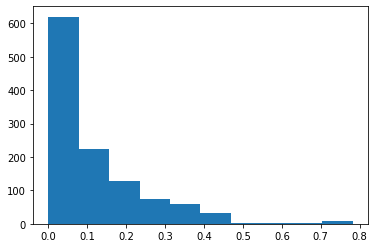

In [28]:
plt.hist(final_df.ExsituF)
plt.show()

In [29]:
dataset_dir = 'Dataset_1D'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

save_path = os.path.join(dataset_dir, 'dataset_{}.hdf5'.format(sim_dir))
final_df.to_hdf(save_path, '/data')
